<a href="https://colab.research.google.com/github/Raphlawren/Landshape-Prediction-using-Coordinates/blob/main/01_MovingShape.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import pandas as pd
import numpy as np
from prophet import Prophet

In [19]:
df = pd.read_csv('/content/yearssum.csv')

In [20]:
df.head()

,id,x,y,year
0,1,0.80836,1.02486,2000-01-01
1,2,0.80833,1.02777,2000-01-01
2,3,0.80825,1.03068,2000-01-01
3,4,0.80813,1.03358,2000-01-01
4,5,0.80795,1.03649,2000-01-01


In [21]:
df.year.unique()

array(['2000-01-01', '2001-01-01', '2002-01-01', '2003-01-01',
       '2004-01-01', '2005-01-01', '2006-01-01', '2007-01-01',
       '2008-01-01', '2009-01-01'], dtype=object)

In [33]:
df.head()

,id,x,y,year
0,1,0.80836,1.02486,2000-01-01
1,2,0.80833,1.02777,2000-01-01
2,3,0.80825,1.03068,2000-01-01
3,4,0.80813,1.03358,2000-01-01
4,5,0.80795,1.03649,2000-01-01


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067 entries, 0 to 1066
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   id      1067 non-null   int64         
 1   x       1067 non-null   float64       
 2   y       1067 non-null   float64       
 3   year    1067 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 33.5 KB


In [30]:
df['year'] = pd.to_datetime(df['year'], format='%Y')

In [32]:
from prophet import Prophet
import pandas as pd

predictions = []
unique_points = df["id"].unique()

for point in unique_points:
    point_data = df[df["id"] == point].copy()

    # Make sure 'year' is a datetime:
    if point_data['year'].dtype != 'datetime64[ns]':
        point_data['ds'] = pd.to_datetime(point_data['year'], format='%Y')
    else:
        point_data['ds'] = point_data['year']

    last_year = point_data['ds'].dt.year.max()

    # Fit X‐model
    x_df = point_data[['ds','x']].rename(columns={'x':'y'})
    m_x  = Prophet(yearly_seasonality=False)
    m_x.fit(x_df)

    # Only forecast 1 year ahead (or whatever you need)
    future_x = m_x.make_future_dataframe(periods=1, freq='Y')
    fx       = m_x.predict(future_x)
    # extract only the next‐year row
    next_x   = fx.loc[fx['ds'].dt.year == last_year+1, 'yhat'].iloc[0]

    # Fit Y‐model
    y_df = point_data[['ds','y']].rename(columns={'y':'y'})
    m_y  = Prophet(yearly_seasonality=False)
    m_y.fit(y_df)

    future_y = m_y.make_future_dataframe(periods=1, freq='Y')
    fy       = m_y.predict(future_y)
    next_y   = fy.loc[fy['ds'].dt.year == last_year+1, 'yhat'].iloc[0]

    # Append historical
    for _, r in point_data.iterrows():
        predictions.append({
            'id':   point,
            'year': r['ds'].year,
            'x':    r['x'],
            'y':    r['y']
        })

    # Append new forecast
    predictions.append({
        'id':   point,
        'year': last_year+1,
        'x':    next_x,
        'y':    next_y
    })

predict_df = pd.DataFrame(predictions)
predict_df.to_csv("PredictedCoord.csv", index=False)
print(predict_df.tail())


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 1.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbvay0qcn/r4icfvl2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbvay0qcn/msrj7mde.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52540', 'data', 'file=/tmp/tmpbvay0qcn/r4icfvl2.json', 'init=/tmp/tmpbvay0qcn/msrj7mde.json', 'output', 'file=/tmp/tmpbvay0qcn/prophet_model3wgdo4jq/prophet_model-20250505094251.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
09:42:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:42:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:c

IndexError: single positional indexer is out-of-bounds

In [44]:
from prophet import Prophet
import pandas as pd

predictions = []
unique_points = df["id"].unique()

for point in unique_points:
    point_data = df[df["id"] == point].copy()

    # 1) Ensure 'ds' is datetime
    point_data['ds'] = pd.to_datetime(point_data['year'], format='%Y')

    last_year = point_data['ds'].dt.year.max()
    periods   = 3  # or 3 if you want 3 years ahead

    # 2) Fit X model
    m_x = Prophet(yearly_seasonality=False)
    m_x.fit(point_data[['ds','x']].rename(columns={'x':'y'}))

    future_x = m_x.make_future_dataframe(periods=periods, freq='YE')
    fx       = m_x.predict(future_x)
    x_preds  = fx['yhat'].iloc[-periods:].values  # grab last `periods` predictions

    # 3) Fit Y model
    m_y = Prophet(yearly_seasonality=False)
    m_y.fit(point_data[['ds','y']].rename(columns={'y':'y'}))

    future_y = m_y.make_future_dataframe(periods=periods, freq='YE')
    fy       = m_y.predict(future_y)
    y_preds  = fy['yhat'].iloc[-periods:].values

    # 4) Append historical points
    for _, r in point_data.iterrows():
        predictions.append({
            'id':   point,
            'year': r['ds'].year,
            'x':    r['x'],
            'y':    r['y']
        })

    # 5) Append forecasted points
    for i in range(periods):
        predictions.append({
            'id':   point,
            'year': last_year + i + 1,
            'x':    x_preds[i],
            'y':    y_preds[i]
        })

predicted_df = pd.DataFrame(predictions)
predicted_df.to_csv("PredictedCoords.csv", index=False)
print(predicted_df.tail())


Streaming output truncated to the last 5000 lines.
10:26:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 0.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbvay0qcn/m9j3hkgr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbvay0qcn/_jv2ko7j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40454', 'data', 'file=/tmp/tmpbvay0qcn/m9j3hkgr.json', 'init=/tmp/tmpbvay0qcn/_jv2ko7j.json', 'output', 'file=/tmp/tmpbvay0qcn/prophet_model6aw1vz0b/prophet_model-20250505102654.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:26:54 - cm

       id  year         x         y
2142  360  2001  0.880790  1.020690
2143  360  2002  0.994890  1.018690
2144  360  2003  1.108677  1.016695
2145  360  2004  1.222777  1.014695
2146  360  2005  1.337189  1.012690


In [45]:
predicted_df.head()

,id,year,x,y
0,1,2000,0.808360,1.02486
1,1,2001,0.878950,1.02486
2,1,2002,0.990810,1.02486
3,1,2003,1.102364,1.02486
4,1,2004,1.214224,1.02486


In [46]:
predicted_df.year.unique()

array([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012])

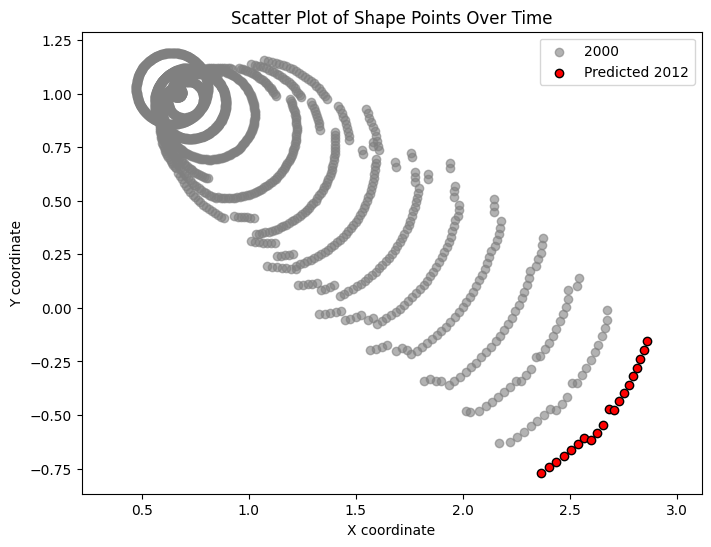

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load predictions
predicted_df = pd.read_csv("PredictedCoords.csv")

# Get years
all_years = sorted(predicted_df['year'].unique())
predicted_year = max(all_years)
historic_years = [yr for yr in all_years if yr != predicted_year]

plt.figure(figsize=(8, 6))

# Plot historical points as gray scatter
for yr in historic_years:
    df_year = predicted_df[predicted_df['year'] == yr]
    plt.scatter(df_year['x'], df_year['y'], color='gray', alpha=0.6, label=f"{yr}" if yr == historic_years[0] else "")

# Plot predicted points as red scatter
df_pred = predicted_df[predicted_df['year'] == predicted_year]
plt.scatter(df_pred['x'], df_pred['y'], color='red', label=f"Predicted {predicted_year}", edgecolor='black')

plt.legend()
plt.axis('equal')
plt.title("Scatter Plot of Shape Points Over Time")
plt.xlabel("X coordinate")
plt.ylabel("Y coordinate")
plt.show()


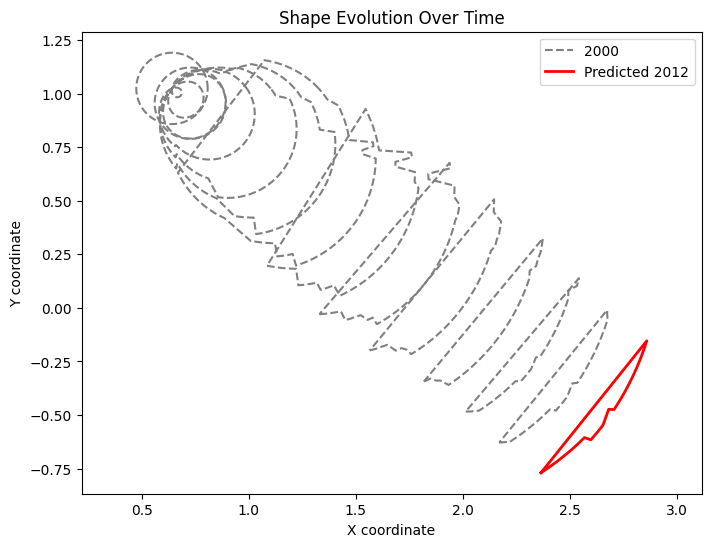

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load your predictions (adjust path if needed)
predicted_df = pd.read_csv("PredictedCoords.csv")

# Determine which years are historic vs predicted
all_years = sorted(predicted_df['year'].unique())
predicted_year = max(all_years)
historic_years = [yr for yr in all_years if yr != predicted_year]

plt.figure(figsize=(8, 6))

# Plot historic shapes in muted gray
for yr in historic_years:
    df_year = predicted_df[predicted_df['year'] == yr].sort_values('id')
    x = df_year['x'].values
    y = df_year['y'].values
    # Close the polygon
    x = np.append(x, x[0])
    y = np.append(y, y[0])
    plt.plot(x, y, color='gray', linestyle='--', label=f"{yr}" if yr == historic_years[0] else "")

# Plot the predicted shape in a standout color
df_pred = predicted_df[predicted_df['year'] == predicted_year].sort_values('id')
x_pred = np.append(df_pred['x'].values, df_pred['x'].values[0])
y_pred = np.append(df_pred['y'].values, df_pred['y'].values[0])
plt.plot(x_pred, y_pred, color='red', linewidth=2, label=f"Predicted {predicted_year}")

plt.legend()
plt.axis('equal')
plt.title("Shape Evolution Over Time")
plt.xlabel("X coordinate")
plt.ylabel("Y coordinate")
plt.show()


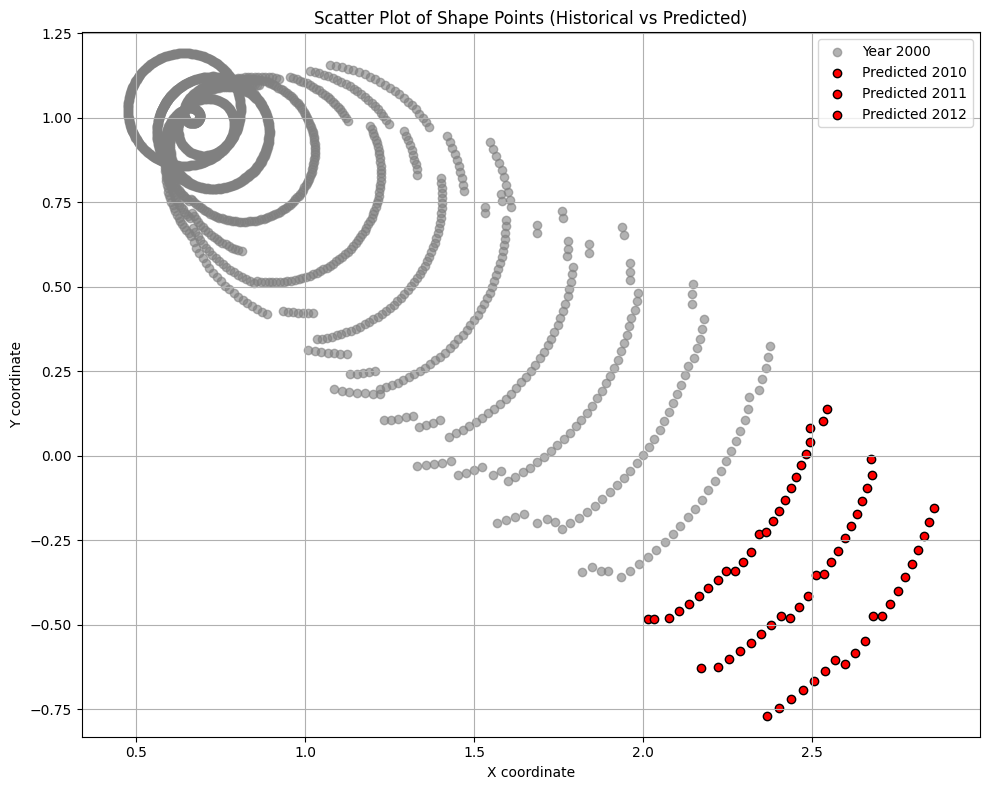

In [50]:
# Reload essentials after the crash
import pandas as pd
import matplotlib.pyplot as plt

# Load predicted coordinates
predicted_df = pd.read_csv("PredictedCoords.csv")

# Ensure year is treated as string for consistent plotting
predicted_df['year'] = predicted_df['year'].astype(str)

# Identify predicted years by finding the latest ones
years_sorted = sorted(predicted_df['year'].unique())
predicted_years = years_sorted[-3:]  # assuming the last 3 years are predicted
historical_years = [yr for yr in years_sorted if yr not in predicted_years]

plt.figure(figsize=(10, 8))

# Plot historical data in gray
for yr in historical_years:
    df_year = predicted_df[predicted_df['year'] == yr]
    plt.scatter(df_year['x'], df_year['y'], color='gray', alpha=0.6, label=f"Year {yr}" if yr == historical_years[0] else "")

# Plot predicted data in red
for yr in predicted_years:
    df_pred = predicted_df[predicted_df['year'] == yr]
    plt.scatter(df_pred['x'], df_pred['y'], color='red', edgecolor='black', label=f"Predicted {yr}")

plt.title("Scatter Plot of Shape Points (Historical vs Predicted)")
plt.xlabel("X coordinate")
plt.ylabel("Y coordinate")
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.tight_layout()
plt.show()


In [59]:
print(predicted_df.head())
print(predicted_df.year.unique())

   id  year         x        y
0   1  2000  0.808360  1.02486
1   1  2001  0.878950  1.02486
2   1  2002  0.990810  1.02486
3   1  2003  1.102364  1.02486
4   1  2004  1.214224  1.02486
[2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012]
